In [1]:
import time
from random import randrange, uniform, sample, random
from copy import copy
import math
import numpy as np
import pandas as pd

from geometry import Geometry as geom
from population import Offspring
from utils import Utilities as util

from ladybug.epw import EPW
from PIL import Image, ImageFilter

In [2]:
from population import Collection, Individual

In [3]:
collection = Collection(r'F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\case_2', "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\colormap.csv")

In [4]:
directions = ['South', 'West', 'North', 'East']
angles = [0, 90, 180, 270]

In [5]:
domains = [(0, 0,   1.8, [120, 120, 255], 'sitting long' ),
           (1, 1.8, 3.6, [120, 255, 255], 'sitting short'),
           (2, 3.6, 5.3, [120, 255, 120], 'walking slow' ),
           (3, 5.3, 7.6, [255, 255, 120], 'walking fast' ),
           (4, 7.6, 15,  [255, 197, 110], 'uncomfortable'),
           (5, 15,  100, [255, 120, 120], 'dangerous'    )]

In [6]:
input_height_map = Image.open(
    "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\individual_0.png")

In [7]:
ind = Individual(collection, 5, collection.cmap, (512,512))

F:\PhD_Research\Software\Mine\archElites\geometry.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polygons = np.array(np.vsplit(points.reshape(-1, 1), np.cumsum(splits)))[:-1]


In [8]:
for an in angles:
    img = util.rotate_input(ind.draw_image(), an)
    img.save(r'F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\individual_{}.png'.format(an))

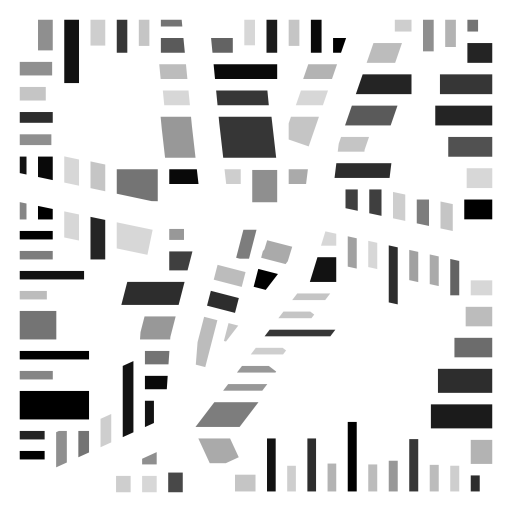

In [9]:
util.rotate_to_origin(util.rotate_input(ind.draw_image(), 270), 512, 512, -270)

In [8]:
from inference import run_inf

In [11]:
import time

In [13]:
time.time()

1603757427.8402977

In [49]:
t = time.time()
run_inf()
e = time.time()
print('total time: %f' % (e-t))

Finished inference
total time: 2.286662


In [12]:
epw_file = r'C:\Users\user\ladybug_tools\resources\weather\USA_MA_Boston-Logan.Intl.AP.725090_TMY3\USA_MA_Boston-Logan.Intl.AP.725090_TMY3.epw'

In [13]:
def parse_epw(epw_file):
    # Extract Wind Direction and Speed Pairs
    epw = EPW(epw_file)
    wind_pairs = []
    for wd, ws in zip(epw.wind_direction.values, epw.wind_speed.values):
        if wd != 999 and ws != 999:
            if wd == 360:
                wd = 0
            wind_pairs.append((wd, ws))

    return wind_pairs

In [14]:
pairs = parse_epw(epw_file)
pairs = np.array(pairs)

In [15]:
# South
cond_s = np.logical_and(pairs[:, 0] >= 135,  pairs[:, 0] < 225)
south_cat = np.where(cond_s)[0]
# East
cond_e = np.logical_and(pairs[:, 0] >= 45,  pairs[:, 0] < 135)
east_cat = np.where(cond_e)[0]
# North
cond_n = np.logical_or(pairs[:, 0] >= 270,  pairs[:, 0] < 45)
north_cat = np.where(cond_n)[0]
# West
cond_w = np.logical_and(pairs[:, 0] >= 225,  pairs[:, 0] < 270)
west_cat = np.where(cond_w)[0]

assert south_cat.shape[0] + east_cat.shape[0] + north_cat.shape[0] + west_cat.shape[0] == pairs.shape[0]

In [16]:
pairs = pd.DataFrame(pairs, columns=['wd', 'ws'])

pairs.loc[south_cat, 'wd'] = 180
pairs.loc[east_cat, 'wd']  = 90
pairs.loc[north_cat, 'wd'] = 0
pairs.loc[west_cat, 'wd']  = 270

In [17]:
wind_counts = np.unique(np.array(pairs['wd']), return_counts=True)[1]
wind_counts

array([4159, 1458, 1797, 1346], dtype=int64)

In [18]:
def remap_wind(pil_img, size=(256, 256)):
    pil_img = Image.open(pil_img).resize(size)
    pil_img = pil_img.convert('HSV')
    h, s, v = pil_img.split()
    remap = lambda h: int(170 * ((-(h - 170) / 85) + 1))
    hue = [remap(max(170, h_)) for h_ in h.getdata()]
    h.putdata(hue)
    s.putdata([170] * len(hue))
    v.putdata([255] * len(hue))
    return Image.merge('HSV', (h, s, v)).convert('RGB')

In [19]:
def wind_factors(pil_img):
    #pil_img = Image.open(pil_img)
    min_hue, max_hue = 170, 255
    if pil_img.mode != 'HSV':
        pil_img = pil_img.convert('HSV')
    pil_img = pil_img.filter(ImageFilter.BLUR)
    hue_npa = np.array(pil_img).astype(float)[:, :, 0]
    return 1 - hue_npa / min_hue

In [20]:
def snapshot(pil_img, input_height_map, wind_speed):
    law_npa = wind_speed * wind_factors(pil_img)
    map_npa = np.full((*law_npa.shape, 3), 255)
    lawson_values = np.full((*law_npa.shape, 1), 0)
    mask_npa = np.array(input_height_map.convert('L'))
    mask_npa[mask_npa < 255] = 0
    total_area = mask_npa.sum()
    for dom in domains:
        cond = (law_npa >= dom[1]) & (law_npa <= dom[2]) & (mask_npa == 255)
        map_npa[..., :][cond] = dom[3]
        lawson_values[..., :][cond] = dom[0]
    return Image.fromarray(np.uint8(map_npa), mode="RGB"), lawson_values, total_area

In [34]:
lawson_0 = np.load(
    "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\lawson_0.npy").astype(int)
lawson_90 = np.load(
    "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\lawson_90.npy").astype(int)
lawson_180 = np.load(
    "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\lawson_180.npy").astype(int)
lawson_270 = np.load(
    "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\lawson_270.npy").astype(int)

# Fake yearly

In [22]:
yearly = np.ceil(((lawson_0 * wind_counts[0] + lawson_90 * wind_counts[1] + lawson_180 * wind_counts[2] 
          + lawson_270 * wind_counts[3]) / sum(wind_counts))).astype(int)

In [23]:
yearly_img = np.full((512, 512, 3), 255)

In [24]:
for i in range(yearly.shape[0]):
    for j in range(yearly.shape[1]):
        yearly_img[i, j, :] = domains[yearly[i, j][0]][3]

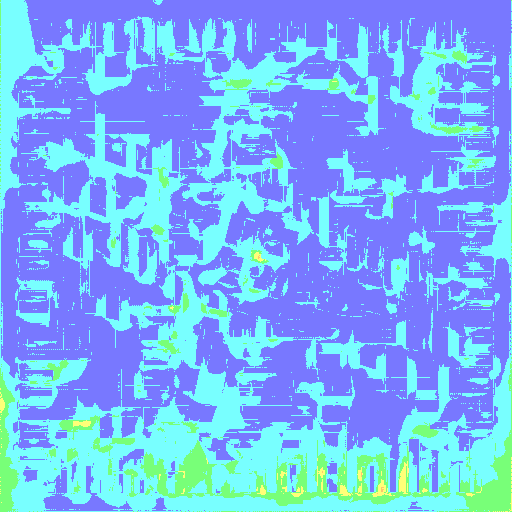

In [25]:
Image.fromarray(np.uint8(yearly_img), mode="RGB")

In [44]:
all_values = [lawson_0, lawson_90, lawson_180, lawson_270]

yearly = np.ceil(((all_values[0] * wind_counts[0] + all_values[1] * wind_counts[1] + all_values[2] * wind_counts[2] 
                   + all_values[3] * wind_counts[3]) / sum(wind_counts))).astype(int)

In [45]:
yearly_img = np.full((512, 512, 3), 255)

In [46]:
for i in range(yearly.shape[0]):
    for j in range(yearly.shape[1]):
        yearly_img[i, j, :] = domains[yearly[i, j][0]][3]

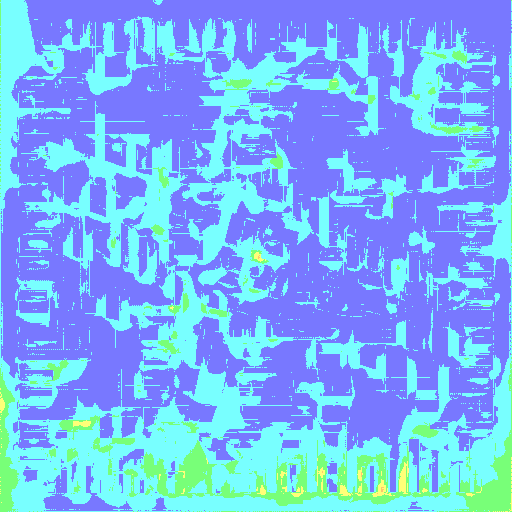

In [47]:
Image.fromarray(np.uint8(yearly_img), mode="RGB")

In [26]:
yearly = np.ceil(((lawson_0 + lawson_90 + lawson_180 + lawson_270) / 4)).astype(int)

In [27]:
yearly_img = np.full((512, 512, 3), 255)

In [29]:
for i in range(yearly.shape[0]):
    for j in range(yearly.shape[1]):
        yearly_img[i, j, :] = domains[yearly[i, j][0]][3]

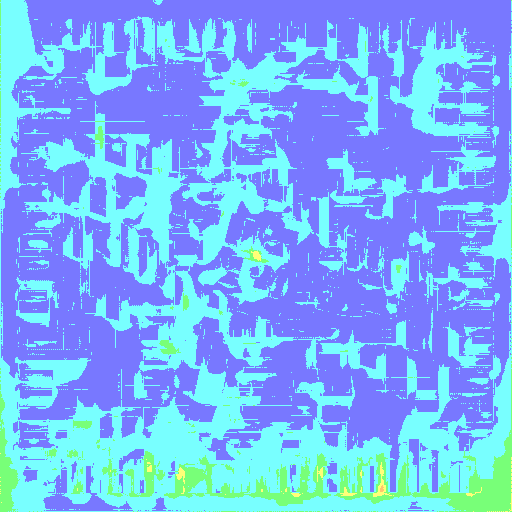

In [30]:
Image.fromarray(np.uint8(yearly_img), mode="RGB")

# Proper yearly

In [39]:
def yearly(wind_factor_npa, input_height_map, wind_pairs, size=(256, 256)):
    mask_npa = np.array(input_height_map.convert('L').resize(size))
    mask_npa[mask_npa < 255] = 0

    # Find Lawson Criteria for Hourly Maps
    counted_hours = len(wind_pairs)
    lawson_npa = np.zeros((counted_hours, *reversed(input_height_map.size)))
    for hr_idx, wp in enumerate(wind_pairs):
        wd, ws = wp
        vel_npa = wind_factor_npa[wd//10] * ws
        for dom in domains:
            cond = (vel_npa >= dom[1]) & (vel_npa <= dom[2]) & (mask_npa == 255)
            lawson_npa[hr_idx][cond] = dom[0]

    # Use Lawson Thresholds for a Single Yearly Comfort Map
    yearly_lawson_npa = np.full((*mask_npa.shape, 3), 255)
    ls = lawson_npa.shape
    for i in range(ls[1]):
        for j in range(ls[2]):

            # Counter
            uni = np.unique(lawson_npa[:, i, j], return_counts=True)
            uni = np.pad(uni[1][uni[0].argsort()], (0, 6-len(uni)))

            # Thresholds
            threshold = 0.98 * counted_hours
            if uni[0] >= threshold:
                yearly_lawson_npa[i][j] = domains[0][3]
            elif sum(uni[:2]) >= threshold:
                yearly_lawson_npa[i][j] = domains[1][3]
            elif sum(uni[:3]) >= threshold:
                yearly_lawson_npa[i][j] = domains[2][3]
            elif sum(uni[:4]) >= threshold:
                yearly_lawson_npa[i][j] = domains[3][3]
            elif uni[3] > 0.02 * counted_hours and uni[5] < 2:
                yearly_lawson_npa[i][j] = domains[4][3]
            else:
                yearly_lawson_npa[i][j] = domains[5][3]

    return Image.fromarray(np.uint8(yearly_lawson_npa), mode="RGB")

In [ ]:
yearly

In [45]:
pairs_sorted = pairs.sort_values(by='wd')
counts = wind_counts.cumsum()

dir_0 = pairs_sorted[:counts[0]]['ws'].values
dir_1 = pairs_sorted[counts[0]:counts[1]]['ws'].values
dir_2 = pairs_sorted[counts[1]:counts[2]]['ws'].values
dir_3 = pairs_sorted[counts[2]:counts[3]]['ws'].values

In [46]:
prediction_0 = "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\prediction_0.png"
prediction_1 = "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\prediction_90.png"
prediction_2 = "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\prediction_180.png"
prediction_3 = "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\prediction_270.png"

In [47]:
wf_0 = wind_factors(remap_wind(prediction_0))
year_0 = [ws * wf_0 for ws in dir_0]
wf_1 = wind_factors(remap_wind(prediction_1))
year_1 = [ws * wf_1 for ws in dir_1]
wf_2 = wind_factors(remap_wind(prediction_2))
year_2 = [ws * wf_2 for ws in dir_2]
wf_3 = wind_factors(remap_wind(prediction_3))
year_3 = [ws * wf_3 for ws in dir_3]

In [48]:
yearly_wf = np.vstack((year_0, year_1, year_2, year_3)).squeeze()
yearly_wf.shape

(8760, 256, 256)

In [49]:
del wf_0, wf_1, wf_2, wf_3
del year_0, year_1, year_2, year_3

In [61]:
counted_hours = len(pairs)
lawson_npa = np.zeros((counted_hours, *reversed((256,256))))

In [78]:
for hr_idx, wf in enumerate(yearly_wf):
    for dom in domains:
        cond = (wf >= dom[1]) & (wf <= dom[2]) & (mask_npa == 255)
        lawson_npa[hr_idx][cond] = dom[0]

In [80]:
# Use Lawson Thresholds for a Single Yearly Comfort Map
yearly_lawson_npa = np.full((*mask_npa.shape, 3), 255)
ls = lawson_npa.shape
for i in range(ls[1]):
    for j in range(ls[2]):

        # Counter
        uni = np.unique(lawson_npa[:, i, j], return_counts=True)
        uni = np.pad(uni[1][uni[0].argsort()], (0, 6-len(uni)))

        # Thresholds
        threshold = 0.98 * counted_hours
        if uni[0] >= threshold:
            yearly_lawson_npa[i][j] = domains[0][3]
        elif sum(uni[:2]) >= threshold:
            yearly_lawson_npa[i][j] = domains[1][3]
        elif sum(uni[:3]) >= threshold:
            yearly_lawson_npa[i][j] = domains[2][3]
        elif sum(uni[:4]) >= threshold:
            yearly_lawson_npa[i][j] = domains[3][3]
        elif uni[3] > 0.02 * counted_hours and uni[5] < 2:
            yearly_lawson_npa[i][j] = domains[4][3]
        else:
            yearly_lawson_npa[i][j] = domains[5][3]

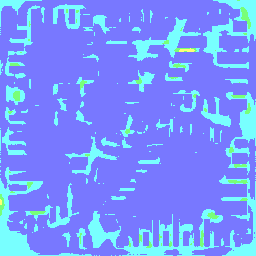

In [81]:
Image.fromarray(np.uint8(yearly_lawson_npa), mode="RGB")

In [50]:
lawson_results = np.load(
    "F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\yearly_lawson.npy")

In [52]:
total_area = np.load(r"F:\PhD_Research\CaseStudies\MAP-Elites\pv_urban\inference_server\minimal-ml-serverCPU\inferences\area_0.npy")

In [54]:
unique, counts = np.unique(lawson_results, return_counts=True)

In [55]:
unique

array([0, 1, 2, 3, 4])

In [56]:
unique, counts = np.unique(lawson_results, return_counts=True)

try:
    sitting = np.sum(counts[np.where(unique==0)[0]])
except:
    sitting = 0

try:
    dangerous = np.sum(counts[np.where(unique>=4)[0]])
except:
    dangerous = 0

sitting_percentage = (sitting / total_area.item()) * 100
dangerous_percentage = (dangerous / total_area.item()) * 100

#lawson_sitting.append(sitting_percentage)
#lawson_dangerous.append(dangerous_percentage)

In [57]:
sitting_percentage, dangerous_percentage

(0.3019646277328311, 4.804273882045467e-05)

In [60]:
sitting/4,2

(37712.0, 2)

In [61]:
dangerous/4.2

5.714285714285714